In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import gmsh

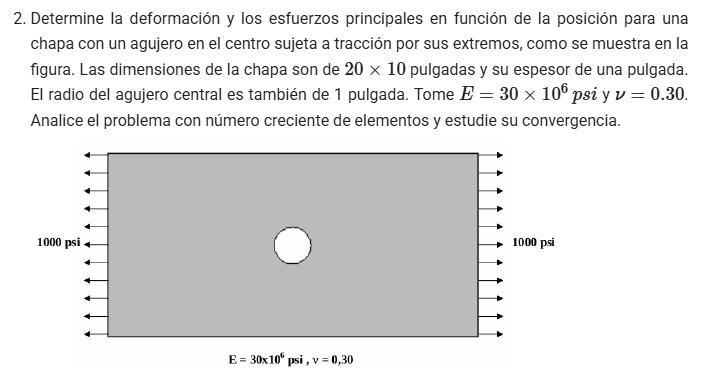

In [2]:
L = 20
a = 10
e = 1
R = 1

E = 30e6
v = 0.30

F = 1000

In [3]:
gmsh.initialize()
gmsh.model.add('Chapa')

In [4]:
P = [
    gmsh.model.geo.addPoint(0,0,0,1),
    gmsh.model.geo.addPoint(R,0,0,0.1),
    gmsh.model.geo.addPoint(L/2,0,0,1),
    gmsh.model.geo.addPoint(L/2,a/2,0,1),
    gmsh.model.geo.addPoint(0,a/2,0,1),
    gmsh.model.geo.addPoint(0,R,0,0.1)
]

In [5]:
L = [
    gmsh.model.geo.addLine(P[1],P[2]),
    gmsh.model.geo.addLine(P[2],P[3]),
    gmsh.model.geo.addLine(P[3],P[4]),
    gmsh.model.geo.addLine(P[4],P[5]),
    gmsh.model.geo.addCircleArc(P[5],P[0],P[1])
]

In [6]:
C1 = gmsh.model.geo.addCurveLoop(L)

In [7]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [8]:
gmsh.model.geo.synchronize()

In [9]:
gmsh.model.mesh.generate(2)
gmsh.fltk.run()

In [10]:
EmpotradoX = gmsh.model.addPhysicalGroup(1,[L[3]])
gmsh.model.setPhysicalName(1,EmpotradoX,'EmpotradoX')

EmpotradoY = gmsh.model.addPhysicalGroup(1,[L[0]])
gmsh.model.setPhysicalName(1,EmpotradoY,'EmpotradoY')

Traccionado = gmsh.model.addPhysicalGroup(1,[L[1]])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(1,Superficie,'Superficie')

In [11]:
NodeInfo = gmsh.model.mesh.get_nodes_for_physical_group(2,Superficie)
NumeroNodos = NodeInfo[0].shape[0]

MN = NodeInfo[1].reshape(NumeroNodos,3)

ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

MC = ELEMENTS.reshape(ETAGS.shape[0],3)

#   Hasta aca tengo mi matriz de Nodos y Conectividades

In [12]:
#   Necesito definir las condiciones de contorno --- Me queda terminar las C.C para identificar. 



entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1,Traccionado)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1,entityTraccionada[0])

In [13]:
Ltraccionada = Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2)

Longitudes = np.abs(MN[Ltraccionada[:,0]-1,1] - MN[Ltraccionada[:,1]-1,1])

#........................................................................................

Fuerzas = np.zeros((2*NumeroNodos,1))
espesor = 1
tension = 1000

for l, linea in enumerate(Ltraccionada):
    Flocal = np.array([[1],[1]])*tension*espesor*Longitudes[1]/2
    n1 = linea[0]
    n2 = linea[1]
    Fuerzas[np.array([2*(n1-1), 2*(n2-1)],dtype = int)] += Flocal


Desplazamientos = np.zeros((2*NumeroNodos,1))
Exy =  np.hstack((Fuerzas.reshape(NumeroNodos,2) , np.zeros((NumeroNodos,1))))


In [14]:
NodosEmpotradosX = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoX)
NodosEmpotradosY = gmsh.model.mesh.get_nodes_for_physical_group(1,EmpotradoY)

In [15]:
s = []
for n,nodo in enumerate(NodosEmpotradosX[0]):
    s.append(2*(nodo-1))

for n,nodo in enumerate(NodosEmpotradosY[0]):
    s.append(2*(nodo-1)+1)

s = np.array(s).astype(int).ravel()
r = np.linspace(0, 2*(NumeroNodos-1)+1, 2*NumeroNodos)
r = np.delete(r,s)

In [16]:
ETYPES = 2*np.ones(len(MC)).astype(int)